#### Use unsupervised One-Class support Vector Machine to detect ouliers

- Unlike the regular supervised SVM, the one-class SVM does not have target labels for the model training process.
- it learns the boundary for the normal data points and identifies the data outside the border to be anomalies.

In [4]:
# Synthetic dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt

# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Step 2: Create an Imbalanced Dataset

In [5]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

Step 3: Train Test Split

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


Step 4: Train One-Class Support Vector Machine (SVM) Model

check this hyperparameter

- nu is to specify the percentage of anomalies. nu=0.01 means that we have around 1% outliers in the dataset.
- Kernel specifies the kernel type. The radial basis function (rbf) kernel is a commonly used kernel type. It maps data from a low dimensional space to a high dimensional space to help the SVM model draw a decision boundary.
- gamma is a kernel coefficient, and it is for 'rbf', 'poly', and 'sigmoid' kernels. When setting it to 'auto', the kernel coefficient is 1 over the number of features.

In [7]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

Step 5: Predict Anomalies
- By default, one-class SVM labels the normal data points as 1s and anomalies as -1s. 
- To compare the labels with the ground truth in the testing dataset, we changed the anomalies’ labels from -1 to 1, and the normal labels from 1 to 0.

In [10]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)

# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]

# Check the model performance
print(classification_report(y_test, prediction))

#The model has a recall values of 6%, meaning that it captures 6% of the anomaly data points.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



Step 6: Customize Predictions Using Scores

In [11]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)

# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')

# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]

# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 182.62
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



Step 7: Visualization

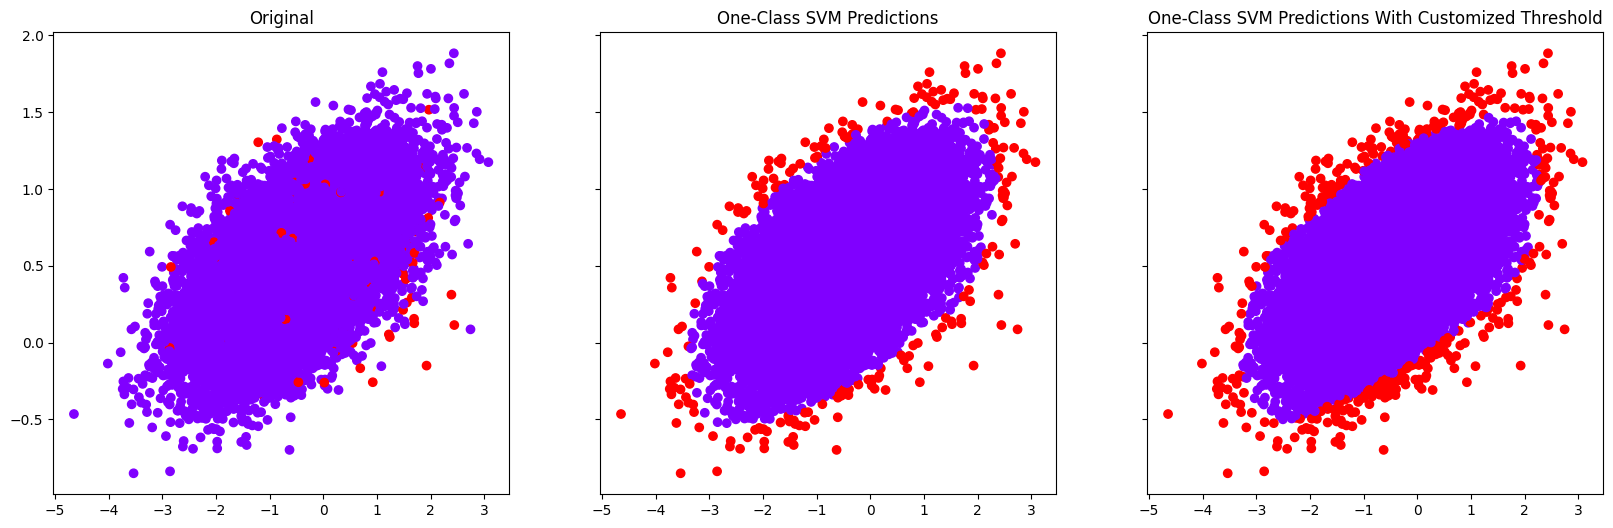

In [12]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction

# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))

# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], 
            cmap='rainbow')

# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'],
            cmap='rainbow')